### 문제정의

주택 가격을 예측하는 모델을 만들어보겠습니다. 주택 가격에 영향을 미치는 특성(feature)과 해당 주택의 가격을 지도학습으로 모델에 학습시키서, 임의의 특성을 입력하면, 주택 가격을 예측하는 것입니다.

### 데이터셋

본 예제에서 사용하는 데이터셋은 케라스에서 제공되는 보스턴 주택 가격 데이터셋을 사용합니다. 상세한 내용은 아래 링크에서 보실 수 있습니다.

https://keras.io/api/datasets/boston_housing/

특성은 총 13개이며 아래와 같습니다. 범죄율, 방 개수, 세금 등이 보입니다.

 * CRIM : per capita crime rate by town
 * ZN : proportion of residential land zoned for lots over 25,000 sq.ft.
 * INDUS : proportion of non-retail business acres per town
 * CHAS : Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 * NOX : nitric oxides concentration (parts per 10 million)
 * RM : average number of rooms per dwelling
 * AGE : proportion of owner-occupied units built prior to 1940
 * DIS : weighted distances to five Boston employment centres
 * RAD : index of accessibility to radial highways
 * TAX : full-value property-tax rate per $10,000
 * PTRATIO : pupil-teacher ratio by town
 * B : 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 * LSTAT : % lower status of the population
 
학습시키고자 하는 타겟 인자는 아래와 같습니다. 단위가 1000달러인 주택 가격입니다.

 * MEDV : Median value of owner-occupied homes in $1000's

훈련샘플은 404개이고, 시험샘플은 102개입니다. 데이터셋은 케라스 패키지에서 제공되는 것을 사용하겠습니다.

In [1]:
from keras.datasets import boston_housing
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


데이터셋의 샘플 수와 특성 수를 확인해봅니다.

In [2]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(404, 13)
(404,)
(102, 13)
(102,)


시험셋 샘플 하나를 먼저 확인해보겠습니다.

In [3]:
x_test[0]

array([ 18.0846,   0.    ,  18.1   ,   0.    ,   0.679 ,   6.434 ,
       100.    ,   1.8347,  24.    , 666.    ,  20.2   ,  27.25  ,
        29.05  ])

머신러닝 모델은 훈련셋을 학습시킨 다음, 추론하는 것이기에 데이터셋에 대한 통계를 확인하는 것이 중요합니다. 훈련셋의 데이터와 라벨를 통합하여 전체 히스토그램을 확인해보겠습니다. 히스토그램은 구간별(x축)로 얼마나 많은 빈도(y축)이 있는 지를 나타낸 것입니다.

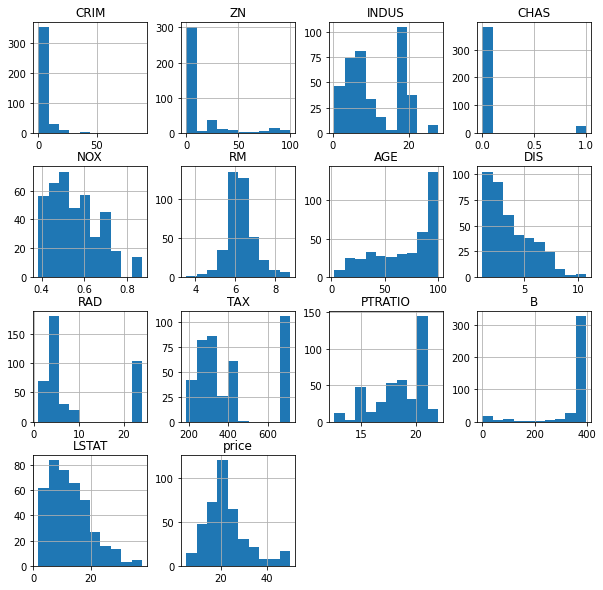

In [4]:
import numpy as np
import pandas as pd

train_set = np.concatenate((x_train, np.expand_dims(y_train, axis=-1)), axis=1)
train_df = pd.DataFrame(train_set)

train_df = train_df.rename(columns={0 : 'CRIM',
                                    1 : 'ZN',
                                    2 : 'INDUS',
                                    3 : 'CHAS',
                                    4 : 'NOX',
                                    5 : 'RM',
                                    6 : 'AGE',
                                    7 : 'DIS',
                                    8 : 'RAD',
                                    9 : 'TAX',
                                    10 : 'PTRATIO',
                                    11 : 'B',
                                    12 : 'LSTAT',
                                    13 : 'price'})

histo = train_df.hist(figsize = [10, 10])

### 데이터셋 전처리

특성 변수의 값 범위가 특성마다 스케일이 달라서 정규화가 필요합니다. 정규화된 값을 모델에 입력하는 것이 학습 관점에서 유리합니다. 정규화는 평균과 분산을 이용하여 수행합니다. 학습셋에 사용한 정규화 파라미터를 시험셋에도 적용합니다. 추후에 모델을 사용할 때도 학습때 사용된 정규화 파라미터를 사용해야 합니다.

In [5]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

### 모델 정의

데이터셋 샘플 수가 적어 교차검증을 할 것이기 때문에 모델을 매번 생성하기 쉽게 만들기 위해서 함수로 정의합니다.

손실함수는 회귀분석이기 때문에 평균 제곱 오차를 사용하였고, 학습 모니터링에 사용하는 매트릭으로는 평균 절대 오차를 사용했습니다. 평균 절대 오차를 사용하면 직관적으로 오차값을 이해하는 데 용이합니다. "1"이면 1000달러만큼 오차가 나는 것이고, "0.2"면 200달러만큼 오차가 발생하는 것을 의미합니다.

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(13,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### 교차검증

데이터셋 샘플 수가 비교적 적기 때문에 교차검증을 통해서 모델을 검증합니다. 본 예제에서는 4차 교차검증을 수행합니다. 즉 데이터셋을 4등분해서, 한 그룹을 검증셋으로 두고 나머지 3개 그룹으로 학습시켜서 그 결과를 기록합니다. 이 과정을 검증셋을 바꿔가면서 총 4회를 실행한 후 그 결과를 평균 내서, 검증 수치를 산출합니다.

In [7]:
import numpy as np
k = 4
num_val_samples = len(x_train) // k
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in  range(k):
    print("processing fold #", i)

    # 검증 데이터 분리
    x_val = x_train[i * num_val_samples : (i+1) * num_val_samples]
    y_val = y_train[i * num_val_samples : (i+1) * num_val_samples]

    # 훈련 데이터 분리
    partial_x_train = np.concatenate([x_train[:i*num_val_samples], x_train[(i + 1) * num_val_samples:]], axis=0)
    partial_y_train = np.concatenate([y_train[:i*num_val_samples], y_train[(i + 1) * num_val_samples:]], axis=0)

    # 모델 학습
    model = build_model()
    history = model.fit(partial_x_train, partial_y_train, validation_data=(x_val, y_val), epochs=num_epochs, batch_size=16)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
    val_mse, val_mae = model.evaluate(x_val, y_val, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Epoch 1/500
19/19 [==============================] - 14s 30ms/step - loss: 572.1289 - mae: 21.7789 - val_loss: 413.2906 - val_mae: 18.2152
Epoch 2/500
19/19 [==============================] - 0s 4ms/step - loss: 377.3832 - mae: 17.7439 - val_loss: 269.1227 - val_mae: 14.3101
Epoch 3/500
19/19 [==============================] - 0s 3ms/step - loss: 263.8817 - mae: 14.2073 - val_loss: 139.5588 - val_mae: 9.6360
Epoch 4/500
19/19 [==============================] - 0s 4ms/step - loss: 142.6454 - mae: 9.6136 - val_loss: 62.8146 - val_mae: 5.6316
Epoch 5/500
19/19 [==============================] - 0s 4ms/step - loss: 68.0913 - mae: 6.2917 - val_loss: 37.9907 - val_mae: 3.9607
Epoch 6/500
19/19 [==============================] - 0s 3ms/step - loss: 37.1296 - mae: 4.6058 - val_loss: 28.6405 - val_mae: 3.3294
Epoch 7/500
19/19 [==============================] - 0s 3ms/step - loss: 36.4076 - mae: 4.1906 - val_loss: 25.1771 - val_mae: 3.1151
Epoch 8/500
19/19 [================

### 학습 커브 가시화

교차 검증이 수행되기 때문에, 매 에포크마다 mae를 산출하기위해 각 교차검증 시 해당하는 에포크의 mae을 모두 더해 평균을 내서 사용합니다.

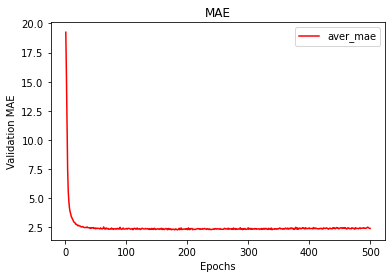

In [8]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, 'r', label='aver_mae')
plt.title('MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

지수 이동 평균으로 곡선을 부드럽게 만듭니다.

In [9]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

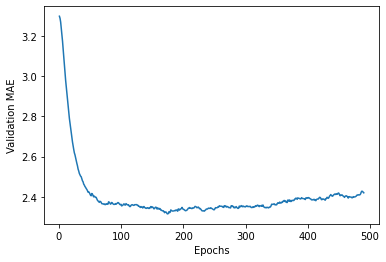

In [10]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 최종 모델 선정 및 평가

학습 커브에서 최적 하이퍼파라미터를 찾았다면, 해당 파라미터로 최적 모델을 학습하고 평가를 수행합니다.

In [11]:
model = build_model()
model.fit(x_train, y_train, epochs=80, batch_size=16, verbose=0)

시험셋으로 2천달러 이상 차이가 나는 것을 확인할 수 있습니다.

In [12]:
x_test -= mean
x_test /= std

test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

print(test_mae_score)

4/4 [==============================] - 0s 3ms/step - loss: 21.0858 - mae: 3.0155
3.0154950618743896


### 제출용 모델 결과 파일 저장

시험셋으로 테스트한 결과를 제출하기 위해 모델 결과 파일을 저장합니다. 

In [13]:
y_pred = model.predict(x_test)
np.savetxt('y_pred.csv', y_pred, fmt='%f')